# Imports Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [7]:
df = pd.read_csv('Heart_Disease_Prediction.csv')
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


# EDA

# Heart Disease Distribution

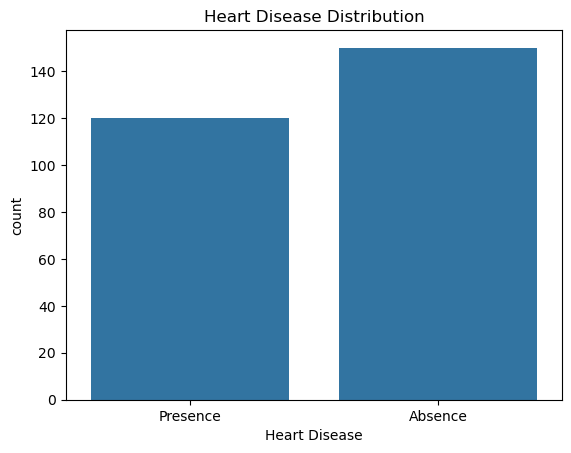

In [11]:
sns.countplot(data=df, x='Heart Disease')
plt.title("Heart Disease Distribution")
plt.show()

# Age Distribution

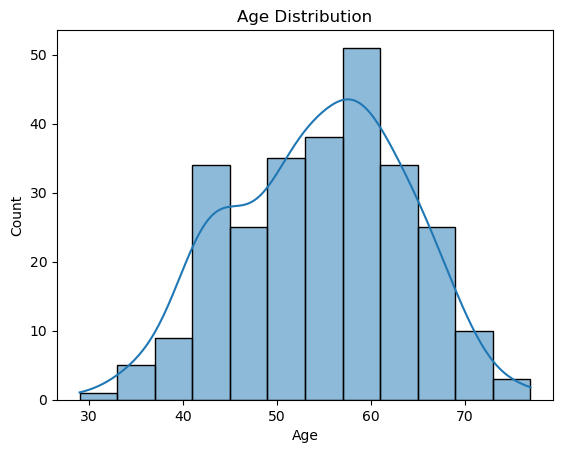

In [14]:
sns.histplot(df['Age'], kde=True)
plt.title("Age Distribution")
plt.show()

# Sex vs Heart Disease

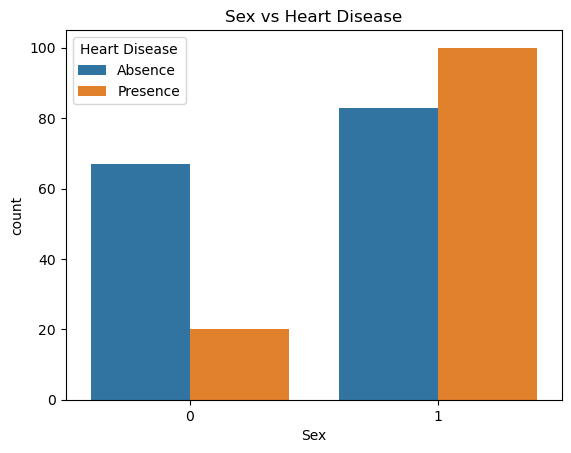

In [17]:
sns.countplot(data=df, x='Sex', hue='Heart Disease')
plt.title("Sex vs Heart Disease")
plt.show()

# Chest Pain Type

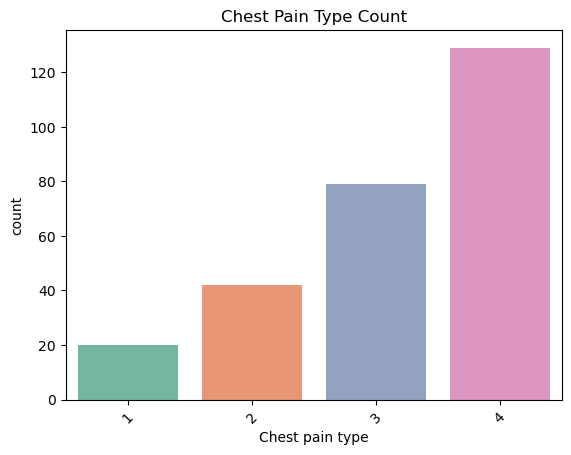

In [20]:
sns.countplot(data=df, x='Chest pain type', palette='Set2')
plt.title("Chest Pain Type Count")
plt.xticks(rotation=45)
plt.show()

# Age vs Max HR

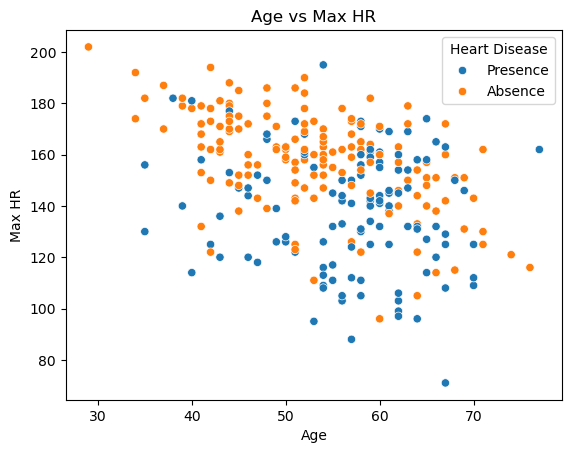

In [27]:
sns.scatterplot(data=df, x='Age', y='Max HR', hue='Heart Disease')
plt.title("Age vs Max HR")
plt.show()

# Correlation Heatmap

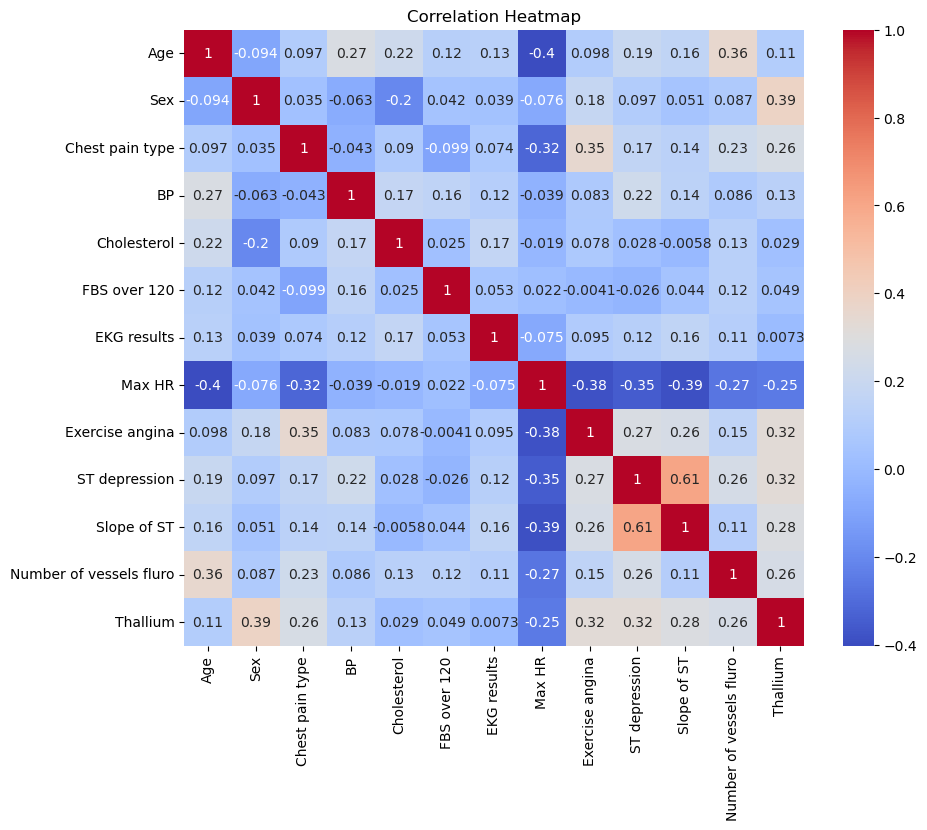

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# FBS over 120

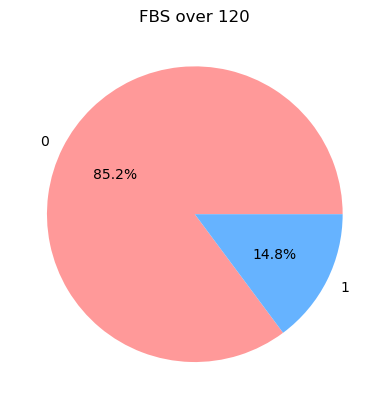

In [33]:
fbs = df['FBS over 120'].value_counts()
plt.pie(fbs, labels=fbs.index, autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title("FBS over 120")
plt.show()

# Slope of ST vs Age

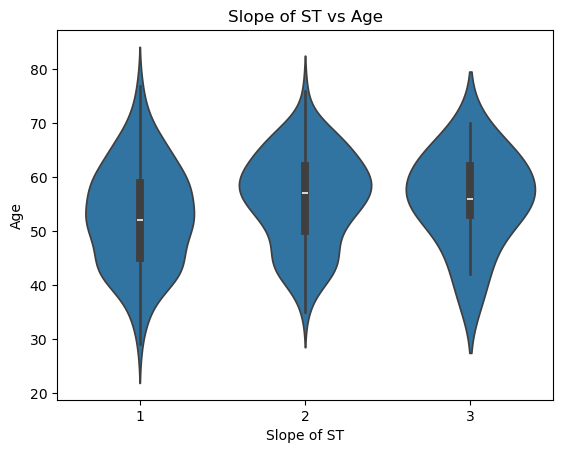

In [36]:
sns.violinplot(data=df, x='Slope of ST', y='Age')
plt.title("Slope of ST vs Age")
plt.show()

In [41]:
# Step 4: One-Hot Encoding
df_encoded = pd.get_dummies(df, drop_first=True)

In [43]:
# Step 5: Split Features and Target
target_col = [col for col in df_encoded.columns if 'Heart Disease' in col][0]
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

In [45]:
# Step 6: Balance Data with SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
print("Balanced class distribution:\n", y_resampled.value_counts())


Balanced class distribution:
 Heart Disease_Presence
True     150
False    150
Name: count, dtype: int64


In [47]:
# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scaling

In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Modeling & Evaluation

In [71]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')}

for name, model in models.items():
    print(f"\n MODEL: {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print(f" Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    print(classification_report(y_test, y_pred))


 MODEL: Logistic Regression
 Accuracy: 0.9000
ROC-AUC: 0.8999
              precision    recall  f1-score   support

       False       0.90      0.90      0.90        31
        True       0.90      0.90      0.90        29

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60


 MODEL: Random Forest
 Accuracy: 0.8500
ROC-AUC: 0.8515
              precision    recall  f1-score   support

       False       0.89      0.81      0.85        31
        True       0.81      0.90      0.85        29

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


 MODEL: XGBoost
 Accuracy: 0.8000
ROC-AUC: 0.8031
              precision    recall  f1-score   support

       False       0.88      0.71      0.79        31
        True       0.74      0.90      0.81        29

    accurac

# Confusion Matrix

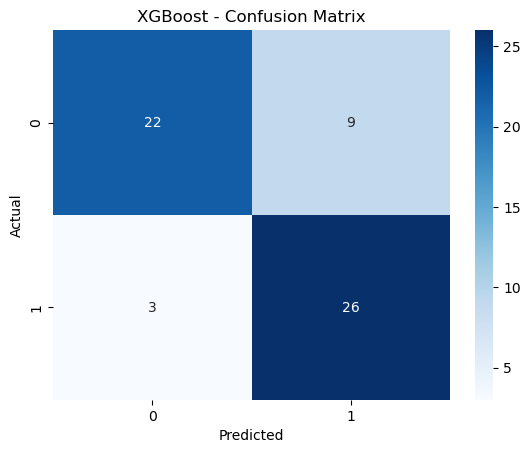

In [61]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{name} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve

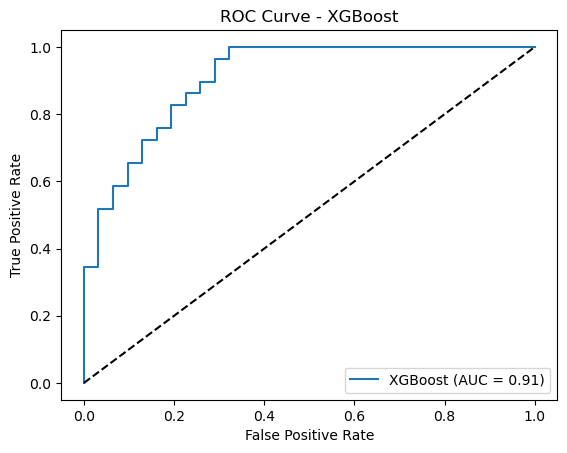

In [65]:
y_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"ROC Curve - {name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Key Insights

- Age and Chest Pain Type show clear patterns with heart disease occurrence.

- Cholesterol and Thallium test results are strong predictors of heart disease risk.

- Patients with Exercise-induced Angina had a higher chance of heart disease.

- A strong correlation exists between Max Heart Rate and Heart Disease presence.

- Data Cleaning: Removed duplicates and encoded categorical variables

- EDA : Visualized key patterns in age, cholesterol, chest pain, and heart disease distribution

- Class Imbalance Handling: Used SMOTE to balance the dataset

- Best Model: XGBoost with ~80% accuracy and ~90% recall

- Feature Importance: Top contributors include Age, Cholesterol, Thallium test, and Chest pain type

- Confusion Matrix: Low false negatives — only 3 missed cases of actual heart disease

- ROC Curve: AUC score indicates strong model performance

- Real-world Relevance: Focused on reducing false negatives to avoid missing heart patients